In [ ]:
# import cv2
# import mediapipe as mp
# import numpy as np

In [ ]:
# # Initialising 
# mp_drawings = mp.solutions.drawing_utils
# mp_pose = mp.solutions.pose
# pose = mp_pose.Pose()

In [ ]:
# def calculate_angle(a, b, c):
#     a = np.array(a)  # First point
#     b = np.array(b)  # Mid point
#     c = np.array(c)  # End point

#     radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
#     angle = np.abs(radians * 180.0 / np.pi)

#     if angle > 180.0:
#         angle = 360 - angle
#     return angle


In [ ]:
# camera = cv2.VideoCapture(0)
# counter = 0
# stage = None

# while camera.isOpened():
#     status, frame = camera.read()
#     if status == False:
#         break

#     image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     results = pose.process(image)
#     image = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # if results.pose_landmarks:
    #     landmarks = results.pose_landmarks.landmark

#         shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
#                     landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
#         elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
#                  landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
#         wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
#                  landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

#         angle = calculate_angle(shoulder, elbow, wrist)

#         # Curl counter logic
#         if angle > 160:
#             stage = "down"
#         if angle < 50 and stage == "down":
#             stage = "up"
#             counter += 1

#         # Show counter
#         cv2.putText(image, f'Reps: {counter}', (10, 50),
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

#         mp_drawings.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

#     cv2.imshow('Physical Therapy Tracker', image)

#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# camera.release()
# cv2.destroyAllWindows()


In [ ]:
# # import cv2
# # import mediapipe as mp
# import csv
# import os
# import math

# mp_pose = mp.solutions.pose
# mp_drawings = mp.solutions.drawing_utils

# pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# # Function to calculate angle between three points
# def calculate_angle(a, b, c):
#     a = [a[0], a[1]]
#     b = [b[0], b[1]]
#     c = [c[0], c[1]]

#     radians = math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0])
#     angle = abs(radians*180.0/math.pi)
#     if angle > 180.0:
#         angle = 360 - angle
#     return angle

# camera = cv2.VideoCapture(0)

# # CSV file to store angles + labels
# csv_file = "exercise_labeled.csv"
# file_exists = os.path.isfile(csv_file)

# with open(csv_file, mode='a', newline='') as f:
#     csv_writer = csv.writer(f)

#     # Write header only if new file
#     if not file_exists:
#         header = ["exercise", "frame", "elbow_angle", "count", "stage", "form"]
#         csv_writer.writerow(header)

#     frame_count = 0
#     exercise_name = "bicep_curl"  # 🔥 Change this when recording other exercises
#     counter = 0
#     stage = None

#     while camera.isOpened():
#         status, frame = camera.read()
#         if not status:
#             break

#         image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         results = pose.process(image)
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#         if results.pose_landmarks:
#             landmarks = results.pose_landmarks.landmark

#             # Key points for right arm
#             shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
#                         landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
#             elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
#                      landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
#             wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
#                      landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

#             # Calculate angle
#             angle = calculate_angle(shoulder, elbow, wrist)

#             # Determine stage and count reps
#             form = "good"
#             if angle > 160:  # arm extended
#                 stage = "down"
#             if angle < 50 and stage == "down":  # arm curled up
#                 stage = "up"
#                 counter += 1

#                 # Check form correctness
#                 if angle < 30:  # too much curl
#                     form = "bad"
#                 elif angle > 170:  # not curling enough
#                     form = "bad"

#             # Save to CSV
#             row = [exercise_name, frame_count, angle, counter, stage, form]
#             csv_writer.writerow(row)
#             frame_count += 1

#             # Draw pose and info
#             mp_drawings.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

#             cv2.putText(image, f'Angle: {int(angle)}', (10, 50),
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
#             cv2.putText(image, f'Reps: {counter}', (10, 100),
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
#             cv2.putText(image, f'Stage: {stage}', (10, 150),
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
#             cv2.putText(image, f'Form: {form}', (10, 200),
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

#         cv2.imshow('Exercise Tracker - Press Q to stop', image)

#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break

# camera.release()
# cv2.destroyAllWindows()


In [1]:
import cv2
import mediapipe as mp
import csv
import math
import os

mp_pose = mp.solutions.pose
mp_drawings = mp.solutions.drawing_utils

pose = mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

def calculate_angle(a, b, c):

    rads = math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0])
    angle = abs(rads * 180 / math.pi)

    if angle > 180:
        angle = 360 - angle

    return angle

exercise_name = "squat"   # "bicep_curl", "squat", "shoulder_abduction"

camera = cv2.VideoCapture(0)

csv_file = "exercise_labeled.csv"
file_exists = os.path.isfile(csv_file)

with open(csv_file, mode = "a", newline = "") as f:
    csv_writer = csv.writer(f)

    if not file_exists:
        header = ["exercise", "frame", "angle", "count", "stage", "form"]
        csv_writer.writerow(header)

    frame_count = 0
    counter = 0
    stage = None

    while camera.isOpened():
        status, frame = camera.read()
        if not status:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            form = "good"
            angle = None

            if exercise_name == "bicep_curl":
                shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                         landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
                wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                         landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
                
                angle = calculate_angle(shoulder, elbow, wrist)

                if angle > 160:
                    stage = "down"
                if angle < 50 and stage == "down":
                    stage = "up"
                    counter += 1
                if angle < 30 or angle > 170:
                    form = "bad"

            elif exercise_name == "squat":
                hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
                knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,
                        landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
                ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,
                         landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
                
                angle = calculate_angle(hip, knee, ankle)

                if angle > 160:
                    stage = "up"
                if angle < 90 and stage == "up":
                    stage = "down"
                    counter += 1
                if angle < 70 or angle > 170:
                    form = "bad"

            elif exercise_name == "shoulder_abduction":
                hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,
                       landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
                shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                         landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
                
                angle = calculate_angle(hip, shoulder, elbow)

                if angle < 30:
                    stage = "down"
                if angle > 80 and stage == "down":  # arm lifted to side
                    stage = "up"
                    counter += 1
                if angle < 20 or angle > 120:
                    form = "bad"

            # Save to CSV
            if angle is not None:
                row = [exercise_name, frame_count, angle, counter, stage, form]
                csv_writer.writerow(row)

                # Draw pose + info
                mp_drawings.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                cv2.putText(image, f'Angle: {int(angle)}', (10, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(image, f'Reps: {counter}', (10, 100),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
                cv2.putText(image, f'Stage: {stage}', (10, 150),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f'Form: {form}', (10, 200),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

            frame_count += 1

        cv2.imshow('Exercise Tracker - Press Q to stop', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

camera.release()
cv2.destroyAllWindows()

c:\Users\singh\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [8]:
import pandas as pd

df = pd.read_csv("exercise_labeled.csv")
# print(df.columns.tolist())
print(df.columns)


Index(['squat', '0', '178.2116990446334', '0.1', 'up', 'bad'], dtype='object')


Exercise: squat
Total Reps: 4
Good Form: 87, Bad Form: 243
Angle Range: 16.42 - 179.93


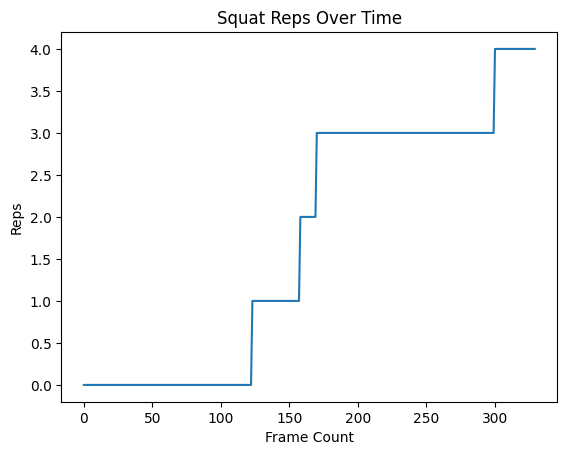

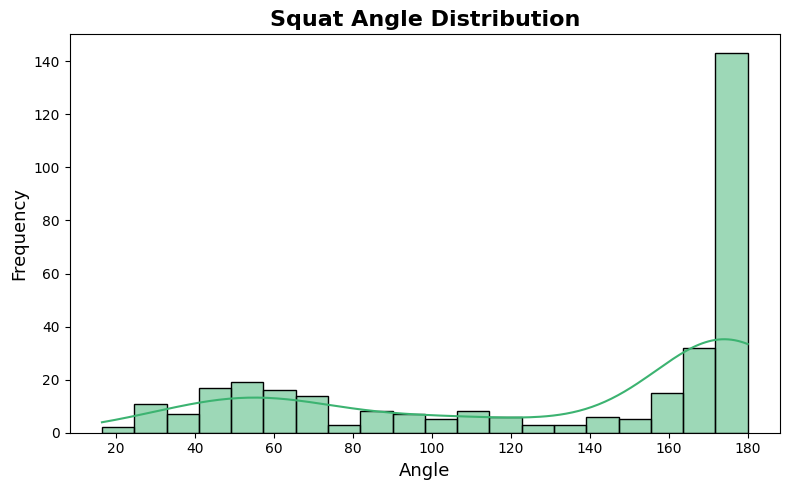

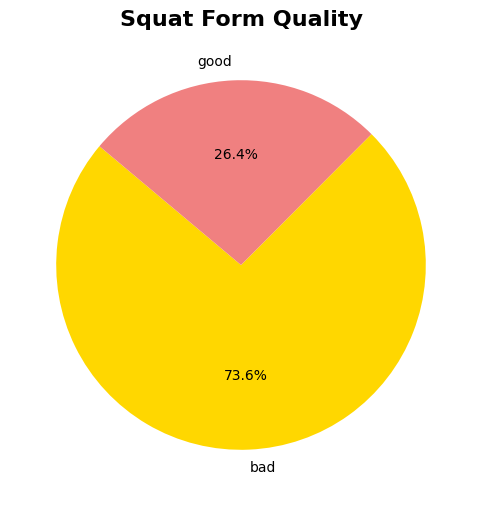

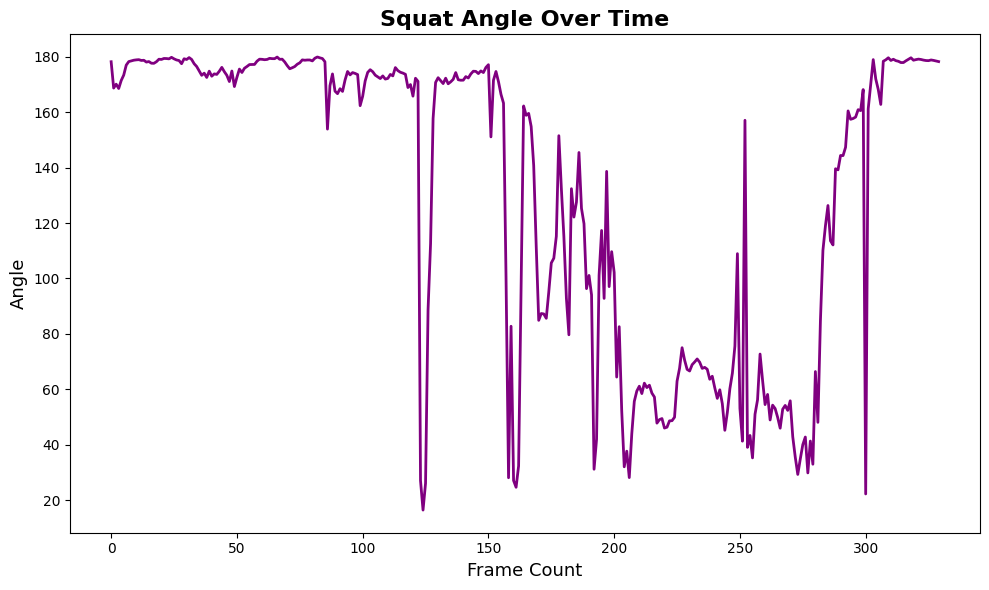

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columns = ["exercise", "frame", "angle", "count", "stage", "form"]
df = pd.read_csv("exercise_labeled.csv", names=columns)

exercise = "squat"
ex_data = df[df["exercise"] == exercise]

total_reps = ex_data["count"].max()
good_form = (ex_data["form"] == "good").sum()
bad_form = (ex_data["form"] == "bad").sum()
min_angle = ex_data["angle"].min()
max_angle = ex_data["angle"].max()

print(f"Exercise: {exercise}")
print(f"Total Reps: {total_reps}")
print(f"Good Form: {good_form}, Bad Form: {bad_form}")
print(f"Angle Range: {min_angle:.2f} - {max_angle:.2f}")

# Visualization: reps vs frames
# plt.plot(ex_data["frame"], ex_data["count"])
# plt.title(f"{exercise.capitalize()} Reps Over Time")
# plt.xlabel("Frame Count")
# plt.ylabel("Reps")
# plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(ex_data["angle"], bins=20, kde=True, color="mediumseagreen")
plt.title(f"{exercise.capitalize()} Angle Distribution", fontsize=16, fontweight="bold")
plt.xlabel("Angle", fontsize=13)
plt.ylabel("Frequency", fontsize=13)
plt.tight_layout()
plt.show()

form_counts = ex_data["form"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(form_counts, labels=form_counts.index, autopct='%1.1f%%', colors=["gold", "lightcoral"], startangle=140)
plt.title(f"{exercise.capitalize()} Form Quality", fontsize=16, fontweight="bold")
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=ex_data["frame"], y=ex_data["angle"], color="purple", linewidth=2)
plt.title(f"{exercise.capitalize()} Angle Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Frame Count", fontsize=13)
plt.ylabel("Angle", fontsize=13)
plt.tight_layout()
plt.show()
